# Анализ результатов АБ-теста
В данном задании вам нужно будет

+ проанализировать АБ  тест,  проведенный на реальных пользователях Яндекса
+ подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control)  и тестовой (exp)  группами
+ определить характер этих изменений и практическую значимость вводимого изменения
+ понять, какая из пользовательских групп более всего проигрывает / выигрывает   от тестируемого изменения (локализовать изменение)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.sandbox.stats.multicomp import multipletests 
import seaborn as sns
from math import ceil

%matplotlib inline

In [2]:
df = pd.read_csv('ab_browser_test.csv')

In [3]:
df.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


### Описание  данных:

+ userID:  уникальный идентификатор пользователя
+ browser:  браузер, который использовал userID
+ slot: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control  = видел неизменную страницу)
+ n_clicks: количество кликов, которые пользоваль совершил за n_queries
+ n_queries: количество запросов, который совершил userID, пользуясь браузером browser
+ n_nonclk_queries: количество запросов пользователя, в которых  им не было совершено ни одного клика

Обращаем ваше внимание, что не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных  уникальным является сочетание userID и browser.

### Вопрос 1
Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы. 

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите  до третьего знака после точки. 

In [4]:
df.slot.value_counts()

control    284554
exp        281580
Name: slot, dtype: int64

In [5]:
#indices split by groups
exp = df.slot.loc[df.slot == 'exp'].index
ctrl = df.slot.loc[df.slot == 'control'].index

In [6]:
#total number of clicks in each group
exp_cl_num = df.n_clicks.loc[exp].sum()
ctrl_cl_num = df.n_clicks.loc[ctrl].sum()
answer1 = ((exp_cl_num-ctrl_cl_num)*100 / ctrl_cl_num)
print('Total number of clicks in each group')
print('Exp: %d' % exp_cl_num)
print('Control: %d' % ctrl_cl_num)
print('Answer 1: %f ' % round(answer1,3))

Total number of clicks in each group
Exp: 3261823
Control: 3210027
Answer 1: 1.614000 


### Вопрос 2

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп. Отметьте все верные утверждения. 

+ 95% доверительный интервал для разности медиан содержит ноль, похоже, медианы существенно не отличаются НЕТ

+ Применение bootstrap на выборках такого большого размера неправомерно, потому что bootstrap делает псведовыборки с возвращениями, а с ростом объема исходной выборки  псведовыборки с возвращениями становятся более похожими на псведовыборки без возвращения. НЕТ

+ 95% доверительный интервал для разности средних содержит ноль, похоже, средние существенно не отличаются НЕТ

+ 95% доверительный интервал для разности медиан не содержит ноль, похоже, медианы отличаются статистически значимо ДА

+ 95% доверительный интервал для разности средних не содержит ноль, похоже, средние отличаются статистически значимо ДА

In [17]:
###### Clicks mean values
exp_cl_mean = df.n_clicks.loc[exp].mean()
ctrl_cl_mean = df.n_clicks.loc[ctrl].mean()
print('Mean number of clicks in each group')
print('Exp: %.4f' % exp_cl_mean)
print('Control: %.4f' % ctrl_cl_mean)
print('')

#Clicks median values
exp_cl_mean = df.n_clicks.loc[exp].median()
ctrl_cl_mean = df.n_clicks.loc[ctrl].median()
print('Median number of clicks in each group')
print('Exp: %d' % exp_cl_mean)
print('Control: %d' % ctrl_cl_mean)

Mean number of clicks in each group
Exp: 11.5840
Control: 11.2809

Median number of clicks in each group
Exp: 5
Control: 4


In [8]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [9]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [10]:
%%time
#confidence intervals estimation
np.random.seed(0)

num_of_samples = 500

exp_cl_mean, ctrl_cl_mean = np.empty(num_of_samples), np.empty(num_of_samples)
exp_cl_median, ctrl_cl_median = np.empty(num_of_samples), np.empty(num_of_samples)

ctrl_cl_var = np.empty(num_of_samples)

exp_data = get_bootstrap_samples(df.n_clicks.loc[exp].values, num_of_samples)
ctrl_data = get_bootstrap_samples(df.n_clicks.loc[ctrl].values, num_of_samples)

for i in range(num_of_samples):
    exp_cl_mean[i], ctrl_cl_mean[i] = exp_data[i].mean(), ctrl_data[i].mean() 
    exp_cl_median[i], ctrl_cl_median[i] = np.median(exp_data[i]), np.median(ctrl_data[i])
    
    ctrl_cl_var[i] = ctrl_data[i].var()

Wall time: 54.4 s
Parser   : 160 ms


In [14]:
delta_mean = list(map(lambda x: x[0] - x[1], zip(exp_cl_mean, ctrl_cl_mean)))
delta_median = list(map(lambda x: x[0] - x[1], zip(exp_cl_median, ctrl_cl_median)))

delta_mean_bnd = stat_intervals(delta_mean, 0.05)
delta_median_bnd = stat_intervals(delta_median, 0.05)

print('Conf. int. delta mean: [%.4f, %.4f]' % (delta_mean_bnd[0], delta_mean_bnd[1]))
print('Conf. int. delta median: [%d, %d]' % (delta_median_bnd[0], delta_median_bnd[1]))
print('legend: diff = exp - control')

Conf. int. delta mean: [0.1996, 0.4050]
Conf. int. delta median: [1, 1]
legend: diff = exp - control


### Вопрос 3
Поскольку данных достаточно много (порядка полумиллиона уникальных пользователей), отличие в несколько процентов может быть не только практически значимым, но и  значимым статистически. Последнее утверждение нуждается в дополнительной проверке. 

Посмотрите на выданные вам данные и выберите все верные варианты ответа относительно проверки гипотезы о равенстве среднего количества кликов в группах. 
1 балл

+ Используя центральную предельную теорему, мы можем заключить, что с ростом объема выборки любое исследуемое распределение, становится похожим на нормальное, а значит, учитывая большой объем нашей выборки, оптимальным критерием  в нашей задаче будет z-критерий.  НЕТ

+ Все ответы неверны НЕТ

+ Для проверки гипотезы о равенстве средних в данной задаче можно использовать только параметрические критерии, потому что непараметрические, как известно, с увеличением размера выборки могут давать непредсказуемые результаты в силу случайности в определении их нулевого распределения. ДА

+ Гипотезу о равенстве средних между двумя выборками можно проверить с помощью построения доверительного интервала для среднего объединенной выборки, потому что в силу большого объема выборки этот интервал будет очень точным, и мы сможем надежно оценить необходимый доверительный интервал НЕТ

+ Для проверки гипотезы о равенстве средних категорически нельзя использовать t-критерий Стьюдента ни при каком размере выборки, потому что количество кликов, которые мы исследуем, больше походят на распределение Пуассона, которое сильно отличается от нормального. НЕТ

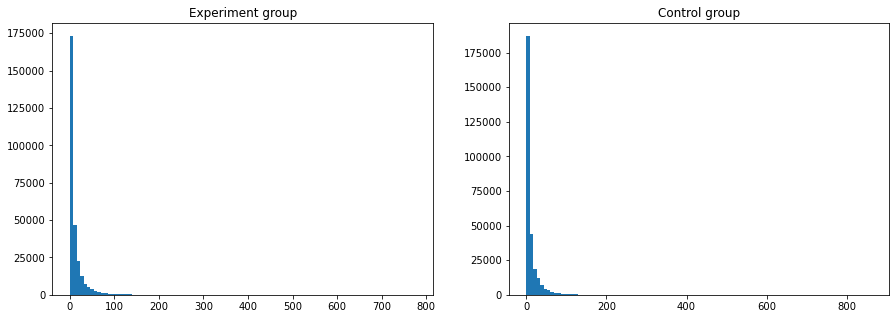

In [15]:
_ = plt.figure(figsize=(15,5))
_ = plt.subplot(121)
_ = plt.hist(df.n_clicks.loc[exp], bins=100)
_ = plt.title('Experiment group')
_ = plt.subplot(122)
_ = plt.hist(df.n_clicks.loc[ctrl], bins=100)
_ = plt.title('Control group')

### Вопрос 4

t-критерий Стьюдента имеет множество достоинств, и потому его достаточно часто применяют в AB экспериментах. Иногда его применение может быть необоснованно из-за сильной скошенности распределения данных. 

Давайте постараемся понять, когда t-критерий можно применять и как это проверить на реальных данных. 

Для простоты рассмотрим одновыборочный t-критерий.  Его статистика имеет вид  Xˉ−μS2/n \frac{\bar{X} - \mu}{ \sqrt {S^2 / n}} S2/n

​Xˉ−μ​, то есть чтобы действительно предположения t-критерия выполнялись необходимо, чтобы:

+    X¯  —  среднее значение в выборке — было распределено нормально N(μ,σ2n)
+    nσ2S2  — несмещенная оценка дисперсии c масштабирующим коэффициентом —  была распределена по хи-квадрат  c n−1 степенями свободы  χ2(n−1) 

Простое доказательство необходимости и достаточности этого требования  можно посмотреть в самом последнем абзаце этого вопроса. Усвоение этого доказательства не обязательно для выполнения задания.

Оба этих предположения можно проверить с помощью бутстрепа. Ограничимся сейчас только контрольной группой, в которой распределение кликов будем называть данными  в рамках данного вопроса. 

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. Для этого 

+    Получите из данных n_boot_samples  псевдовыборок. 
+    По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared) 
+    Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
+    Для получившегося вектора  сумм квадратов отклонения от выборочного среднего постройте  qq-plot с помощью scipy.stats.probplot  для хи-квадрат распределения 

In [55]:
np.random.seed(0)
n_boot_samples = 500

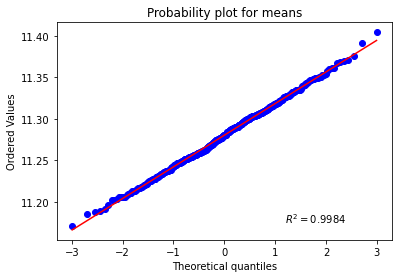

In [56]:
#probability plot for means
_ = stats.probplot(ctrl_cl_mean, plot=plt, rvalue=True)
_ = plt.title('Probability plot for means')

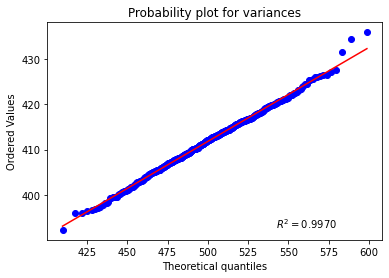

In [57]:
#probability plot for variances
_ = stats.probplot(ctrl_cl_var, plot=plt, dist='chi2', sparams=(ctrl_cl_mean.shape[0]-1), rvalue=True)
_ = plt.title('Probability plot for variances')

### Вопрос 5

Одним из возможных аналогов t-критерия, которым можно воспрользоваться, является тест Манна-Уитни. На достаточно обширном классе распределений он является асимптотически более эффективным, чем t-критерий, и при этом не требует параметрических предположений о характере распределения.

Разделите выборку на две части, соответствующие control  и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю  соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы:

+ Критерий Манна-Уитни в данной задаче применять нельзя, поэтому вопрос о достигаемом уровне значимости некорректен НЕТ

+ Получившееся значение достигаемого уровня значимости свидетельствует о статистической значимости отличий между  двумя выборками ДА

+ p<0.01, поэтому можно сказать, что отличия незначительны на уровне доверия 0.05 НЕТ

+ Согласно полученному значению p-value,  мы вынуждены принять нулевую гипотезу НЕТ

In [18]:
users_nclicks_exp = df.loc[exp].groupby(['userID', 'browser']).sum().loc[:,'n_clicks']
users_nclicks_ctrl = df.loc[ctrl].groupby(['userID', 'browser']).sum().loc[:,'n_clicks']

users_nclicks_exp.head()

userID  browser   
1       Browser #2    23
3       Browser #4     3
5       Browser #4    29
7       Browser #4    54
9       Browser #4     6
Name: n_clicks, dtype: int64

In [19]:
users_nclicks_ctrl.head()

userID  browser    
6       Browser #4     12
8       Browser #4      4
10      Browser #4     22
15      Browser #14     2
23      Browser #4      3
Name: n_clicks, dtype: int64

In [20]:
stats.mannwhitneyu(users_nclicks_exp, users_nclicks_ctrl, alternative='two-sided')

MannwhitneyuResult(statistic=41184125116.0, pvalue=6.247235801369629e-75)

### Вопрос 6

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с α=0.05\alpha=0.05α=0.05.

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции. 5

In [21]:
browsers_nclicks_exp = df.loc[exp].groupby(['browser', 'userID']).sum().loc[:,'n_clicks']
browsers_nclicks_ctrl = df.loc[ctrl].groupby(['browser', 'userID']).sum().loc[:,'n_clicks']

In [30]:
#Unique browsers
browsers = np.unique(df.browser)
print('Unique browsers numbers: ' + str(browsers))
print('')

print('Mann-Whitney rank test without multipletest')
mw_p = np.empty(browsers.shape[0])
for i, br in enumerate(browsers):
    print(br),
    _, mw_p[i] = stats.mannwhitneyu(browsers_nclicks_exp.loc[br, :], browsers_nclicks_ctrl.loc[br, :], alternative='two-sided')
    print('p-value = %.4f' % mw_p[i])

print('')
print('Mann-Whitney rank test with multipletest')
r, mw_p_corr, _, _ = multipletests(mw_p, alpha = 0.05, method = 'holm')
for i, br in enumerate(browsers):
    print(br),
    print('p-value = %.4f' % mw_p_corr[i])

Unique browsers numbers: ['Browser #14' 'Browser #17' 'Browser #2' 'Browser #20' 'Browser #22'
 'Browser #4']

Mann-Whitney rank test without multipletest
Browser #14
p-value = 0.0000
Browser #17
p-value = 0.0748
Browser #2
p-value = 0.0545
Browser #20
p-value = 0.9073
Browser #22
p-value = 0.5148
Browser #4
p-value = 0.8152

Mann-Whitney rank test with multipletest
Browser #14
p-value = 0.0000
Browser #17
p-value = 0.2992
Browser #2
p-value = 0.2724
Browser #20
p-value = 1.0000
Browser #22
p-value = 1.0000
Browser #4
p-value = 1.0000


In [31]:
r

array([ True, False, False, False, False, False])

### Вопрос 7

Для каждого браузера в каждой из двух групп (control  и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений  n_nonclk_queries  на сумму значений  n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче  проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов ? Отметьте все верные утверждения. 

+ По всем браузерам мы видим незначительное уменьшение доли некликнутых запросов, поэтому делаем вывод о том, что тестируемое изменение приносит больше вреда, чем пользы. НЕТ

+ По одному из браузеров мы видим значительное уменьшение доли некликнутых запросов, поэтому уже только на этом основании тестируемое изменение можно рекомендовать к применению для всех пользователей. НЕТ

+ С помощью анализа, проведенного в предыдущем вопросе, мы показали, что тестируемое изменение приводит к статистически значимому отличию только для одного браузера. Для этого браузера на основе данных о доли некликнутых запросов, заключаем, что тестируемое изменение влияет на пользователей позитивно. ДА

+ Тестируемое изменение можно предложить к внедрению только на тот сегмент пользователей, где локализуется изменение, то есть для того браузера, для которого  доля некликнутых запросов уменьшилась больше всего. Для прочих браузеров мы не обладаем никакой информацией относительно влияния тестируемого изменения на поведение пользователей. ДА

In [32]:
browsers_nonclk_q_exp = df.loc[exp].groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_exp = df.loc[exp].groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_exp = browsers_nonclk_q_exp / browsers_clk_q_exp

browsers_nonclk_q_ctrl = df.loc[ctrl].groupby(['browser']).sum().loc[:,'n_nonclk_queries']
browsers_clk_q_ctrl = df.loc[ctrl].groupby(['browser']).sum().loc[:,'n_queries']
browsers_nonclk_q_prop_ctrl = browsers_nonclk_q_ctrl / browsers_clk_q_ctrl

print('Control / experimental groups')
for br in browsers:
    print(br)
    print(browsers_nonclk_q_prop_ctrl.loc[browsers_nonclk_q_prop_ctrl.index == br].values, '/', 
          browsers_nonclk_q_prop_exp.loc[browsers_nonclk_q_prop_ctrl.index == br].values)
    

Control / experimental groups
Browser #14
[0.57590411] / [0.43755617]
Browser #17
[0.36299367] / [0.36937413]
Browser #2
[0.45962747] / [0.44982747]
Browser #20
[0.40540485] / [0.38977376]
Browser #22
[0.40593977] / [0.39853947]
Browser #4
[0.4697093] / [0.45142942]
